In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [2]:
df = pd.read_csv("../data/final/geo_features_us_bank_final.csv")
df = df.dropna(subset=["latitude", "longitude", "total_deposits"])

In [3]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

In [4]:
coords = train_data[["latitude", "longitude"]]
inertia_scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(coords)
    inertia_scores.append((k, kmeans.inertia_))
best_k = sorted(inertia_scores, key=lambda x: x[1])[0][0]
kmeans = KMeans(n_clusters=best_k, random_state=42)
train_data["geo_cluster"] = kmeans.fit_predict(train_data[["latitude", "longitude"]])
test_data["geo_cluster"] = kmeans.predict(test_data[["latitude", "longitude"]])

In [5]:
def add_features(df):
    df["log_nearest_distance"] = np.log1p(df["nearest_competitor_distance_km"])
    df["density_ratio"] = df["total_deposits"] / (df["branch_density_10km"] + 1)
    df["lat_lon_interaction"] = df["latitude"] * df["longitude"]
    return df

train_data = add_features(train_data)
test_data = add_features(test_data)

features = [
    "latitude", "longitude", "log_nearest_distance", "branch_density_10km",
    "geo_cluster", "state", "lat_lon_interaction", "density_ratio"
]

X_train = train_data[features]
y_train_log = np.log1p(train_data["total_deposits"])
X_test = test_data[features]
y_test_log = np.log1p(test_data["total_deposits"])

In [6]:
numeric_features = ["latitude", "longitude", "log_nearest_distance", "branch_density_10km", "geo_cluster", "lat_lon_interaction", "density_ratio"]
categorical_features = ["state"]
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])


In [7]:
y_bins = KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="quantile").fit_transform(y_train_log.values.reshape(-1,1)).astype(int).flatten()

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 400),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 1),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 1),
        "random_state": 42
    }
    xgb = XGBRegressor(**params)
    model = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", xgb)
    ])
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train_log, cv=kf.split(X_train, y_bins), scoring="r2")
    return np.mean(scores)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

d:\geobank\GeoBank\myvenv1\Lib\site-packages\sklearn\preprocessing\_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(
[I 2025-07-08 10:58:43,478] A new study created in memory with name: no-name-ee66cd70-00fe-4ef4-90e6-2420d0793263


[I 2025-07-08 10:58:44,004] Trial 0 finished with value: 0.9283077809717405 and parameters: {'n_estimators': 188, 'max_depth': 3, 'learning_rate': 0.14501594695911993, 'subsample': 0.6825825322588268, 'colsample_bytree': 0.543849670425422, 'gamma': 4.9145892059862755, 'reg_alpha': 0.6699116535103596, 'reg_lambda': 0.7998172772563166}. Best is trial 0 with value: 0.9283077809717405.
[I 2025-07-08 10:58:45,157] Trial 1 finished with value: 0.9178215227853042 and parameters: {'n_estimators': 156, 'max_depth': 7, 'learning_rate': 0.015630568048794445, 'subsample': 0.6729467546750295, 'colsample_bytree': 0.9939614465936654, 'gamma': 3.8419611804390126, 'reg_alpha': 0.49455706143141476, 'reg_lambda': 0.5393260141402374}. Best is trial 0 with value: 0.9283077809717405.
[I 2025-07-08 10:58:45,615] Trial 2 finished with value: 0.9258329682964888 and parameters: {'n_estimators': 105, 'max_depth': 9, 'learning_rate': 0.1865841902292692, 'subsample': 0.6622429514274453, 'colsample_bytree': 0.99157

In [8]:
best_params = study.best_params
best_params["random_state"] = 42
xgb_best = XGBRegressor(**best_params)
final_model = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", xgb_best)
])
final_model.fit(X_train, y_train_log)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Best Parameters: {'n_estimators': 250, 'max_depth': 3, 'learning_rate': 0.2988309589747147, 'subsample': 0.7701239435818354, 'colsample_bytree': 0.6945574567695773, 'gamma': 1.599992340392318, 'reg_alpha': 0.9720822370698711, 'reg_lambda': 0.9815572143806788, 'random_state': 42}
RMSE: 2129484893.3061965
RMSLE: 0.8432053446871735
R^2 Score: 0.8374148082677861


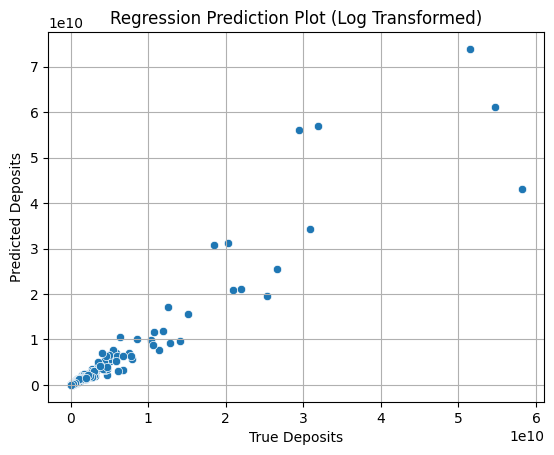

In [9]:
y_pred_log = final_model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test_actual = np.expm1(y_test_log)

rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
r2 = r2_score(y_test_actual, y_pred)
rmsle = np.sqrt(np.mean((y_pred_log - y_test_log) ** 2))

print("Best Parameters:", best_params)
print("RMSE:", rmse)
print("RMSLE:", rmsle)
print("R^2 Score:", r2)

sns.scatterplot(x=y_test_actual, y=y_pred)
plt.xlabel("True Deposits")
plt.ylabel("Predicted Deposits")
plt.title("Regression Prediction Plot (Log Transformed)")
plt.grid(True)
plt.show()

In [11]:
results={
    "RMSE": rmse,
    "RMSLE": rmsle,
    "R^2": r2
}
with open("../backend/api_outputs/regression_results.json", "w") as f:
    json.dump(results, f)